In [18]:
# imports

import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import math
import scipy.stats as st

## Load Datasets

In [19]:
# load the merged dataframes
beers_combined_df = pd.read_csv('data/pMerged/beers_combined_df.csv')
ratings_combined_df = pd.read_csv('data/pMerged/ratings_combined_df.csv')

# load the brewery dataframes
breweries_ba_df = pd.read_csv('data/BeerAdvocate/breweries.csv')
breweries_rb_df = pd.read_csv('data/RateBeer/breweries.csv')

/tmp/ipykernel_6614/2937315645.py:3: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  ratings_combined_df = pd.read_csv('data/pMerged/ratings_combined_df.csv')


## Simple Processing

Create breweries_combined_df dataframe

In [20]:
# process and concatenate brewery dataframes

# BA and RB dont use the same brewery_id's
# --> add column 'dataset' to the brewery dataframes, containing BA and RB respectively
breweries_ba_df['dataset'] = 'BeerAdvocate'
breweries_rb_df['dataset'] = 'RateBeer'

# concatenate the two dataframes
breweries_combined_df = pd.concat([breweries_ba_df, breweries_rb_df], ignore_index=True)

# rename id column of breweries df to brewery_id
breweries_combined_df.rename(columns={'id': 'brewery_id'}, inplace=True)

Add columns to ratings_combined_df

In [21]:
# LOCATION

# add 'location' from the breweries df to the ratings df
# only add BA brewery_id to BA entries and RB brewery_id to RB entries
ratings_combined_df = pd.merge(ratings_combined_df, breweries_combined_df[['brewery_id', 'dataset', 'location']], how='left', on=['brewery_id', 'dataset'])

In [22]:
# ABOVE_AVERAGE, BELOW_AVERAGE

# calculate if a beer is 'above_average' or 'below_average'
# ratings are not equally strict for BA and RB
# --> calculate average_rating for each subset

average_rating_ba = ratings_combined_df[ratings_combined_df['dataset'] == 'BeerAdvocate'].rating.mean()
average_rating_rb = ratings_combined_df[ratings_combined_df['dataset'] == 'RateBeer'].rating.mean()

# compare the rating to average_rating for the respective subset
ratings_combined_df['above_average'] = False
ratings_combined_df.loc[ratings_combined_df['dataset'] == 'BeerAdvocate', 'above_average'] = ratings_combined_df['rating'] > average_rating_ba
ratings_combined_df.loc[ratings_combined_df['dataset'] == 'RateBeer', 'above_average'] = ratings_combined_df['rating'] > average_rating_rb
ratings_combined_df['below_average'] = ~ratings_combined_df['above_average']

In [23]:
# YEAR, MONTH

# Convert the date column to datetime format
ratings_combined_df['date'] = pd.to_datetime(ratings_combined_df['date'])

# Extract year and month into new columns
ratings_combined_df['year'] = ratings_combined_df['date'].dt.year
ratings_combined_df['month'] = ratings_combined_df['date'].dt.month

## Group ratings: product and month

In [25]:
ratings_combined_df.head()

,beer_name,beer_id,brewery_id,brewery_name,style,date,user_id,user_name,appearance,aroma,...,overall,rating,text,year,month,year_month,dataset,location,above_average,below_average
0,Régab,142544,37262,Societe des Brasseries du Gabon (SOBRAGA),Pale Lager,2015-08-20 10:00:00,nmann08.184925,nmann08,3.25,2.75,...,3.0,2.88,"From a bottle, pours a piss yellow color with ...",2015,8,2015-08-01,BeerAdvocate,Gabon,False,True
1,Americano Imperial Coffee IPA,131646,31221,Siren Craft Brew,India Pale Ale (IPA),2014-08-29 10:00:00,nmann08.184925,nmann08,NaN,NaN,...,NaN,3.50,"On draft, pours a dark brown with red hues, wi...",2014,8,2014-08-01,BeerAdvocate,England,False,True
2,Broken Dream,99556,31221,Siren Craft Brew,Sweet Stout,2014-08-29 10:00:00,nmann08.184925,nmann08,NaN,NaN,...,NaN,4.00,"On draft, pours an opaque black with a light b...",2014,8,2014-08-01,BeerAdvocate,England,True,False
3,Maiden 2013,127138,31221,Siren Craft Brew,Barley Wine,2014-08-29 10:00:00,nmann08.184925,nmann08,NaN,NaN,...,NaN,3.75,"On draft, pours a translucent but very dark re...",2014,8,2014-08-01,BeerAdvocate,England,False,True
4,Shattered Dream,135343,31221,Siren Craft Brew,Imperial Stout,2014-08-29 10:00:00,nmann08.184925,nmann08,NaN,NaN,...,NaN,4.00,"On draft, pours a dark brown, pretty much opaq...",2014,8,2014-08-01,BeerAdvocate,England,True,False


In [27]:
# copy the ratings_combined_df to a new dataframe
ratings_beerGroupsMonthly_df = ratings_combined_df.copy()

# group the ratings by beer_id & dataset and take average of rating and sum of above_average
ratings_beerGroupsMonthly_df = ratings_beerGroupsMonthly_df.groupby(['beer_id', 'dataset', 'month']).agg({'beer_name': 'first', 'brewery_id': 'first', 'rating': 'mean', 'above_average': 'sum', 'below_average': 'sum'}).reset_index()
ratings_beerGroupsMonthly_df.rename(columns={'rating': 'average_rating'}, inplace=True)

In [28]:
# add location to the ratings_beerGroupsMonthly_df
ratings_beerGroupsMonthly_df = pd.merge(ratings_beerGroupsMonthly_df, breweries_combined_df[['brewery_id', 'dataset', 'location']], how='left', on=['brewery_id', 'dataset'])

Merging the ratings from the two datasets

In [30]:
ratings_beerGroupsMonthlyMERGED_df = ratings_beerGroupsMonthly_df.copy()

# Normalize
# get the min and max values for average_rating in BA and RB
min_avg_r_BA = ratings_beerGroupsMonthlyMERGED_df[ratings_beerGroupsMonthlyMERGED_df['dataset'] == 'BeerAdvocate'].average_rating.min()
max_avg_r_BA = ratings_beerGroupsMonthlyMERGED_df[ratings_beerGroupsMonthlyMERGED_df['dataset'] == 'BeerAdvocate'].average_rating.max()
min_avg_r_RB = ratings_beerGroupsMonthlyMERGED_df[ratings_beerGroupsMonthlyMERGED_df['dataset'] == 'RateBeer'].average_rating.min()
max_avg_r_RB = ratings_beerGroupsMonthlyMERGED_df[ratings_beerGroupsMonthlyMERGED_df['dataset'] == 'RateBeer'].average_rating.max()

# normalize the average_rating to a scale from 0 to 1 for all entries in BA and RB
ratings_beerGroupsMonthlyMERGED_df.loc[ratings_beerGroupsMonthlyMERGED_df['dataset'] == 'BeerAdvocate', 'average_rating'] = (ratings_beerGroupsMonthlyMERGED_df['average_rating'] - min_avg_r_BA) / (max_avg_r_BA - min_avg_r_BA)
ratings_beerGroupsMonthlyMERGED_df.loc[ratings_beerGroupsMonthlyMERGED_df['dataset'] == 'RateBeer', 'average_rating'] = (ratings_beerGroupsMonthlyMERGED_df['average_rating'] - min_avg_r_RB) / (max_avg_r_RB - min_avg_r_RB)

### Merging average_rating
To correctly get the average_rating, need to:
- weigh average_rating
- take the sum of weighted average_ratings for the same beer
- divide by the sum of weights
  
The aggregate function takes the sum of the weights and the sum of the weighted average_ratings --> only need to divide by the weight, which at this point is the sum of weights.


In [31]:
# create the weights: total number of ratings for each beer --> column 'weight'
ratings_beerGroupsMonthlyMERGED_df['weight'] = ratings_beerGroupsMonthlyMERGED_df['above_average'] + ratings_beerGroupsMonthlyMERGED_df['below_average']

# normalize weight to a scale from 0 to 1 (BUT NO WEIGHT SHOULD BE 0 --> ONLY DIVIDE BY MAX)
max_weight = ratings_beerGroupsMonthlyMERGED_df.weight.max()
ratings_beerGroupsMonthlyMERGED_df['weight'] = ratings_beerGroupsMonthlyMERGED_df['weight'] / max_weight

# weigh average_rating
ratings_beerGroupsMonthlyMERGED_df['average_rating'] = ratings_beerGroupsMonthlyMERGED_df['average_rating'] * ratings_beerGroupsMonthlyMERGED_df['weight']

# group by beer_name and specify how to aggregate the columns (coluns beer_id, dataset and brewery_id are dropped automatically)
ratings_beerGroupsMonthlyMERGED_df = ratings_beerGroupsMonthlyMERGED_df.groupby(['beer_name', 'month']).agg({'location': 'first', 'average_rating': 'sum', 'above_average': 'sum', 'below_average': 'sum', 'weight': 'sum'}).reset_index()

# divide the sum of average_rating by the sum of weight
ratings_beerGroupsMonthlyMERGED_df['average_rating'] = ratings_beerGroupsMonthlyMERGED_df['average_rating'] / ratings_beerGroupsMonthlyMERGED_df['weight']

# drop the weight column
ratings_beerGroupsMonthlyMERGED_df.drop(columns=['weight'], inplace=True)

In [32]:
ratings_beerGroupsMonthlyMERGED_df.head()

,beer_name,month,location,average_rating,above_average,below_average
0,!,4,"United States, New York",0.845000,1,0
1,!,8,"United States, New York",0.812812,7,1
2,!,9,"United States, New York",0.776250,2,0
3,!,10,"United States, New York",0.795000,1,0
4,! (Old Ale),4,Sweden,0.830000,1,0


## Group the ratings for each product, while keeping distinction BA/RB

The goal is to achieve a final grouping by product (a certain beer), however in a first step the grouping needs to happen for each unique beer in EACH dataset independently.

In [33]:
# copy the ratings_combined_df to a new dataframe
ratings_beerGroups_df = ratings_combined_df.copy()

# group the ratings by beer_id & dataset and take average of rating and sum of above_average
ratings_beerGroups_df = ratings_beerGroups_df.groupby(['beer_id', 'dataset']).agg({'beer_name': 'first', 'brewery_id': 'first', 'rating': 'mean', 'above_average': 'sum', 'below_average': 'sum'}).reset_index()
ratings_beerGroups_df.rename(columns={'rating': 'average_rating'}, inplace=True)

In [34]:
# add location to the ratings_beerGroups_df
ratings_beerGroups_df = pd.merge(ratings_beerGroups_df, breweries_combined_df[['brewery_id', 'dataset', 'location']], how='left', on=['brewery_id', 'dataset'])

## Merging the ratings from the two datasets

Perform merge-operation by normalizing and weighing average_rating with the number of ratings they originate from.

In [35]:
ratings_beerGroupsMERGED_df = ratings_beerGroups_df.copy()

# Normalize
# get the min and max values for average_rating in BA and RB
min_avg_r_BA = ratings_beerGroupsMERGED_df[ratings_beerGroupsMERGED_df['dataset'] == 'BeerAdvocate'].average_rating.min()
max_avg_r_BA = ratings_beerGroupsMERGED_df[ratings_beerGroupsMERGED_df['dataset'] == 'BeerAdvocate'].average_rating.max()
min_avg_r_RB = ratings_beerGroupsMERGED_df[ratings_beerGroupsMERGED_df['dataset'] == 'RateBeer'].average_rating.min()
max_avg_r_RB = ratings_beerGroupsMERGED_df[ratings_beerGroupsMERGED_df['dataset'] == 'RateBeer'].average_rating.max()

# normalize the average_rating to a scale from 0 to 1 for all entries in BA and RB
ratings_beerGroupsMERGED_df.loc[ratings_beerGroupsMERGED_df['dataset'] == 'BeerAdvocate', 'average_rating'] = (ratings_beerGroupsMERGED_df['average_rating'] - min_avg_r_BA) / (max_avg_r_BA - min_avg_r_BA)
ratings_beerGroupsMERGED_df.loc[ratings_beerGroupsMERGED_df['dataset'] == 'RateBeer', 'average_rating'] = (ratings_beerGroupsMERGED_df['average_rating'] - min_avg_r_RB) / (max_avg_r_RB - min_avg_r_RB)

### Merging average_rating
To correctly get the average_rating, need to:
- weigh average_rating
- take the sum of weighted average_ratings for the same beer
- divide by the sum of weights
  
The aggregate function takes the sum of the weights and the sum of the weighted average_ratings --> only need to divide by the weight, which at this point is the sum of weights.


In [36]:
# create the weights: total number of ratings for each beer --> column 'weight'
ratings_beerGroupsMERGED_df['weight'] = ratings_beerGroupsMERGED_df['above_average'] + ratings_beerGroupsMERGED_df['below_average']

# normalize weight to a scale from 0 to 1 (BUT NO WEIGHT SHOULD BE 0 --> ONLY DIVIDE BY MAX)
max_weight = ratings_beerGroupsMERGED_df.weight.max()
ratings_beerGroupsMERGED_df['weight'] = ratings_beerGroupsMERGED_df['weight'] / max_weight

# weigh average_rating
ratings_beerGroupsMERGED_df['average_rating'] = ratings_beerGroupsMERGED_df['average_rating'] * ratings_beerGroupsMERGED_df['weight']

# group by beer_name and specify how to aggregate the columns (coluns beer_id, dataset and brewery_id are dropped automatically)
ratings_beerGroupsMERGED_df = ratings_beerGroupsMERGED_df.groupby(['beer_name']).agg({'location': 'first', 'average_rating': 'sum', 'above_average': 'sum', 'below_average': 'sum', 'weight': 'sum'}).reset_index()

# divide the sum of average_rating by the sum of weight
ratings_beerGroupsMERGED_df['average_rating'] = ratings_beerGroupsMERGED_df['average_rating'] / ratings_beerGroupsMERGED_df['weight']

# drop the weight column
ratings_beerGroupsMERGED_df.drop(columns=['weight'], inplace=True)

Is ratings_beerGroupsMERGED_df the same as grouping ratings_beerGroupsMonthlyMERGED_df by beer_name?

In [37]:
ratings_beerGroupsMonthlyMERGED_df.head()

,beer_name,month,location,average_rating,above_average,below_average
0,!,4,"United States, New York",0.845000,1,0
1,!,8,"United States, New York",0.812812,7,1
2,!,9,"United States, New York",0.776250,2,0
3,!,10,"United States, New York",0.795000,1,0
4,! (Old Ale),4,Sweden,0.830000,1,0


In [ ]:
like_beerGroupsMERGED_df_Q = ratings_beerGroupsMonthlyMERGED_df.copy()
# would need to create column weight again
# like_beerGroupsMERGED_df_Q = like_beerGroupsMERGED_df_Q.groupby(['beer_name']).agg({'location': 'first', 'average_rating': 'sum', 'above_average': 'sum', 'below_average': 'sum', 'weight': 'sum'}).reset_index()

## Lower Bound of Wilson

To correctly rank the beers, we will consider the lower bound of Wilson score. 
Wilson lower bound score presents the usefulness value of a product/comment to the user with a 95% confidence interval (https://medium.com/@okanckaya/rating-products-sorting-reviews-aff32cbd29c1).

Here we will consider as negative ratings (i.e bad ratings) the number of ratings that are below the average rating. And we will consider as positive rating (i.e. good rating) the number of ratings that are above the average.

In [38]:
def wilson_lower_bound (pos, neg, confidence=0.95):
    n = pos + neg
    if n == 0:
        return 0
    z = st.norm.ppf(1 - (1 - confidence) / 2)
    phat = 1.0 * pos / n
    return (phat + z * z / (2 * n) - z * math. sqrt ((phat * (1 - phat) + z * z / (4 * n)) / n)) / (1 + z * z / n)

In [39]:
# compute the lower bound of wilson the average rating for each beer
ratings_beerGroupsMERGED_df['lower_bound'] = ratings_beerGroupsMERGED_df.apply(lambda row: wilson_lower_bound(row['above_average'], row['below_average']), axis=1)

# sort the dataframe by the lower bound of the average rating
ratings_beerGroupsMERGED_df.sort_values(by='lower_bound', ascending=False, inplace=True)


In [40]:
ratings_beerGroupsMERGED_df.head()

,beer_name,location,average_rating,above_average,below_average,lower_bound
3060,3 Fonteinen Oude Geuze Vintage (all from 2002-*),Belgium,0.823280,210,0,0.982036
189367,Lost Abbey Isabelle Proximus,"United States, California",0.845354,389,2,0.981544
266109,Russian River Pliny the Younger,"United States, California",0.860782,636,6,0.979762
110258,Evil Twin Double Barrel Jesus,"United States, New York",0.861560,183,0,0.979440
314095,Tilquin Oude Quetsche à lAncienne,Belgium,0.796380,178,0,0.978875


## Location

In [41]:
ratings_beerGroupsMERGED_df['location'].head(20)


3060                        Belgium
189367    United States, California
266109    United States, California
110258      United States, New York
314095                      Belgium
149329       United States, Vermont
149274       United States, Vermont
149341       United States, Vermont
131936      United States, Illinois
334933                      Belgium
149338       United States, Vermont
266108    United States, California
220653                       Sweden
266065    United States, California
149441       United States, Vermont
242129    United States, California
334936                      Belgium
132017      United States, Illinois
220762                       Norway
271002    United States, California
Name: location, dtype: object

## Per-Month Location

In [42]:
# compute the lower bound of wilson the average rating for each beer
ratings_beerGroupsMonthlyMERGED_df['lower_bound'] = ratings_beerGroupsMonthlyMERGED_df.apply(lambda row: wilson_lower_bound(row['above_average'], row['below_average']), axis=1)

# sort the dataframe by the lower bound of the average rating
# ratings_beerGroupsMonthlyMERGED_df.sort_values(by='lower_bound', ascending=False, inplace=True)

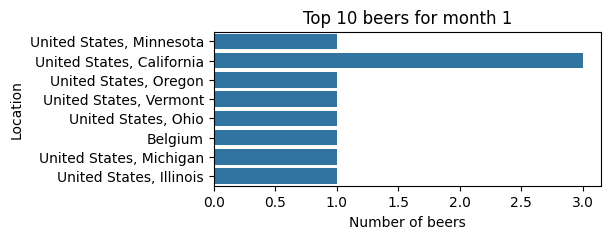

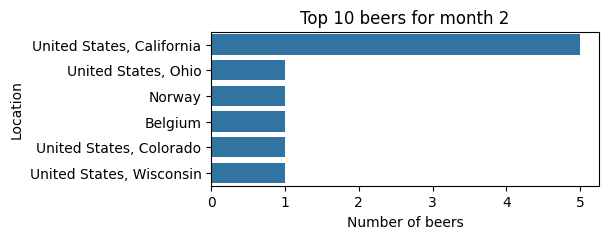

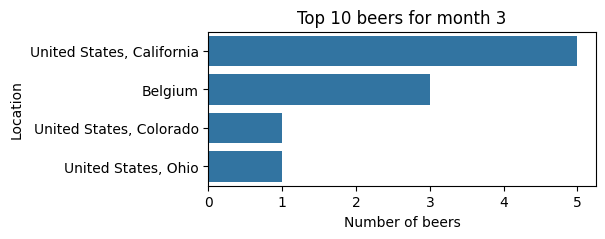

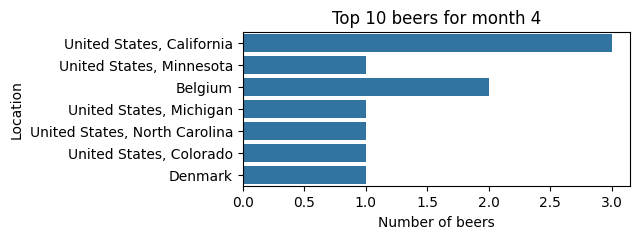

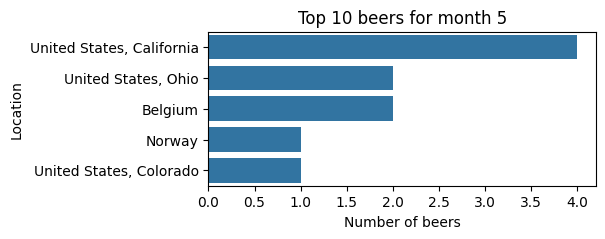

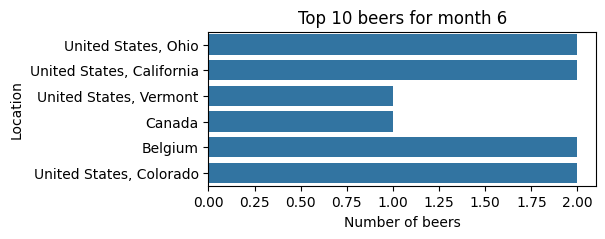

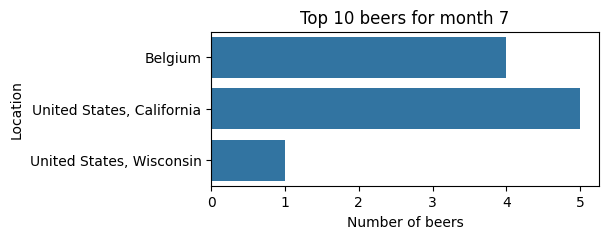

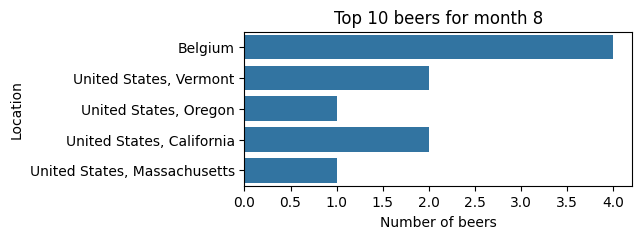

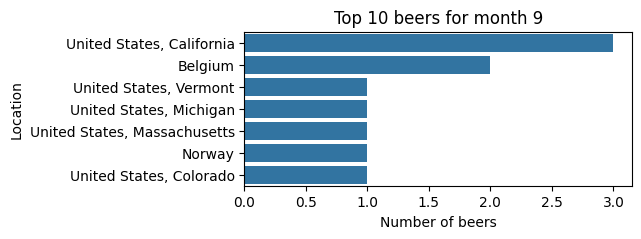

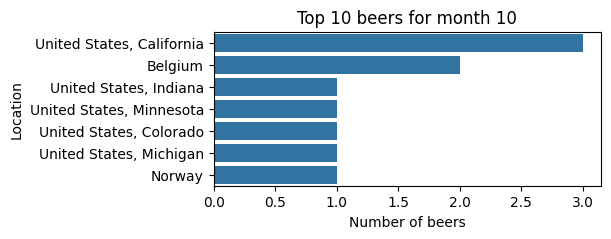

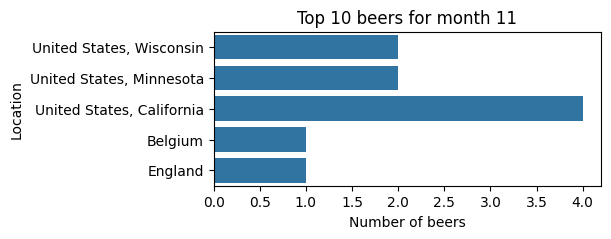

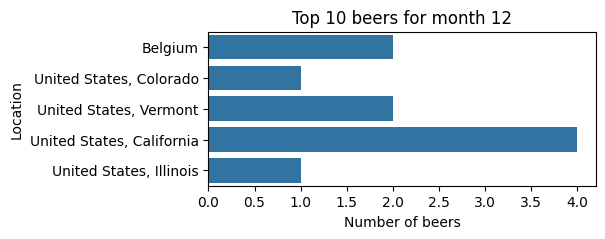

In [45]:
# Plot the location for the top 10 'lower_bound' beers for each month
for month in range(1, 13):
    # select the top 10 beers for the month
    ratings_beerGroupsMonthlyMERGED_df_month = ratings_beerGroupsMonthlyMERGED_df[ratings_beerGroupsMonthlyMERGED_df['month'] == month].sort_values(by='lower_bound', ascending=False).head(10)
    # plot the appereances of locations in the top 10 beers per month
    plt.figure(figsize=(5, 2))
    sns.countplot(y='location', data=ratings_beerGroupsMonthlyMERGED_df_month)
    plt.title('Top 10 beers for month ' + str(month))
    plt.xlabel('Number of beers')
    plt.ylabel('Location')
    # plt.savefig('plots/top10_beers_month_' + str(month) + '.png', bbox_inches='tight')
    plt.show()